<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/pytorch_gradient_test_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install nvidia-384

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  nvidia-384
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 6,852 B of archives.
After this operation, 18.4 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  nvidia-384 418.67-0ubuntu1 [6,852 B]
Fetched 6,852 B in 0s (67.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to fr

In [4]:
!nvidia-smi

Sat Jun  8 01:30:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

In [140]:
import numpy as np
import torch

NUM_ARR = 5
NUM_EPOCH = 20

#참의 계수
w_true = torch.tensor([1,2,3.])
print(type(w_true[0]), w_true[0])

#X 데이터 준비, 절편을 회귀 계수에 포함하기 위해 X의 최소차원에 1을 추가
X = torch. cat([torch.ones(NUM_ARR,1), torch.randn(NUM_ARR,2)],1)
print(type(X[0][0]), X[0][0])

<class 'torch.Tensor'> tensor(1.)
<class 'torch.Tensor'> tensor(1.)


In [141]:
# 참의 계수와 각 X의 내적을 행렬과 벡터의 곱으로 모아서 계산
y = torch.mv(X, w_true) + torch.randn(NUM_ARR) * 0.5
print("y is ",y)

# 기울기 하강으로 최적화 위해 파라미터 Tensor를 난수로 초기화 해서 생성
w= torch.randn(3, requires_grad=True)
print("w is ", w)
print("*"*200)

# 학습률
gamma = 0.1

# 손실함수의 로그
losses = []

# NUM_ARR회 반복
for epoch in range(NUM_EPOCH):
  print("{} epoch info".format(epoch))
  print("start w val : ", w)
  print("[[original]]: \tw.data - {}, \tw.grad - {} ".format(w.data, w.grad))
  
  # 전 회의 backward 메서드로 계산된 grad 경사값을 초기화
  w.grad = None
  print("*** Execute  w.grad = None ***")
  print("[grad to None]: w.data - {}, \tw.grad - {} ".format(w.data, w.grad))
  
  # 선형 모델로 y 예측값을 계산
  y_pred = torch.mv(X,w)
  
  # MSE losses와 w에 의한 미분을 계산으로 현재 Network의 output과 실제 y 값간의 오차, 즉, Error를 계산 (loss (error function) = (실제값 - 모델 예측값)**2/ n )
  loss = torch.mean((y-y_pred)**2)
  
  # Loss(Error) 값을 기준으로 Back propagation 시행하여 각 weight의 비중 결정
  loss.backward()
  # 기존 w값(weight 값)에서 현재 오류에 weight가 얼마만큼의 영향을 끼치는지 계산
  # = 오차에 대한 각 weight의 비중으로 weight가 0이 되면 즉, gradient의 극점에 가면 error와 연관이 없다는 뜻으로 최적화 된것임, 즉, gredient를 최소화 시키는 것이 목표
  # = loss fuction에서(산출 된 Error값에 대해) 각 weight에 대해 미분 = loss.backward()

  # 경사 갱신
  
  # learning rate을 곱한 것 만큼만 weight값을 깎아 오차를 줄여준다.
  
  # w를 그대로 대입해서 갱신하면 다른 텐서가 되어 계산 그래프가 망가진다
  # 따라서 data만 갱신한다.
  
  print("optimizer is \t{} = {} - {} * {}".format(w.data, w.data, gamma, w.grad.data))
  
  w.data = w.data - gamma * w.grad.data
  
  # 수렴 확인을 위한 loss를 기록
  losses.append(loss.item())
  
  print("[[after BP]]: \tw.data - {}, \tw.grad - {}".format(w.data, w.grad))
  print("\ny_pred - {}, \ty_pred.grad_fn  - {}, \ny_real - {}".format(y_pred.data, y_pred.grad_fn, y))
  print("\nloss   - {}, \tloss.grad_fn   - {}".format(loss, loss.grad_fn))
  print("#" * 200)
  
  # 다시 epoch 상단으로 감(수정 된 network에 대한 오류 계산하기 위해)
  # -> ** 이전 epoch에서의 gradient가 누적 될 수 있으니, 다시 현재 network에서의 오류에 대한 weight 비중을 계산하기 위해 w.grade = None으로 초기화
  # -> 현재 네트워크에서의 오류 계산 후 오류에 대한 weight의 비중 즉, gradient 계산(Back Propagation) 
  # -> 현재 weight - learning rate * gradient 적용하여 network update 
  # -> 다시 epoch 실행 반복

y is  tensor([-1.4648,  4.0837, -2.9829,  6.6205,  3.6826])
w is  tensor([-1.6300,  1.0355,  0.8944], requires_grad=True)
********************************************************************************************************************************************************************************************************
0 epoch info
start w val :  tensor([-1.6300,  1.0355,  0.8944], requires_grad=True)
[[original]]: 	w.data - tensor([-1.6300,  1.0355,  0.8944]), 	w.grad - None 
*** Execute  w.grad = None ***
[grad to None]: w.data - tensor([-1.6300,  1.0355,  0.8944]), 	w.grad - None 
optimizer is 	tensor([-1.6300,  1.0355,  0.8944]) = tensor([-1.6300,  1.0355,  0.8944]) - 0.1 * tensor([-6.4892, -4.9724, -3.5884])
[[after BP]]: 	w.data - tensor([-0.9811,  1.5327,  1.2533]), 	w.grad - tensor([-6.4892, -4.9724, -3.5884])

y_pred - tensor([-3.0391, -0.2135, -2.7369,  0.4504, -0.7449]), 	y_pred.grad_fn  - <MvBackward object at 0x7fb6bd2ecf98>, 
y_real - tensor([-1.4648,  4.0837, -2.9829, 

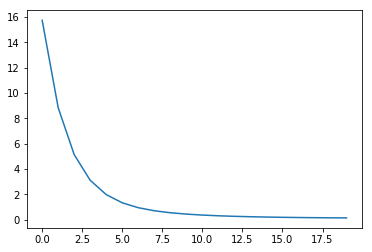

In [142]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(losses)
